
## Классификация изображений из датасета [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)


## Часть 1

Требования

1. Используйте фреймворк [Pytorch](https://pytorch.org/)

2. Не используйте предобученные модели.

3. Можете загрузить готовую модель или использовать собственную архитектуру.

4. Выберите способ оценки качества предсказаний модели. Обоснуйте его.

5. Проведите обучение. Продемонстрируйте умение использовать соответствующие инструменты.

6. Оцените полученный результат.

*Не используйте инструменты принцип работы которых вам непонятен.

### Данные

In [ ]:
!pip install timm torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.4 MB/s eta 0:00:00


#### Библиотеки необходимые для работы

In [ ]:
import torch
import torchvision
from torchvision import models, datasets
import numpy as np
import PIL
import pickle
import numpy as np
from skimage import io
import cuda
import optuna
from optuna.trial import TrialState

from tqdm import tqdm, tqdm_notebook
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns


from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
def imshow(inp, ax, title=None):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.grid(False)

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:18<00:00, 8975026.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### Посморим на изображения, на которых будем обучаться

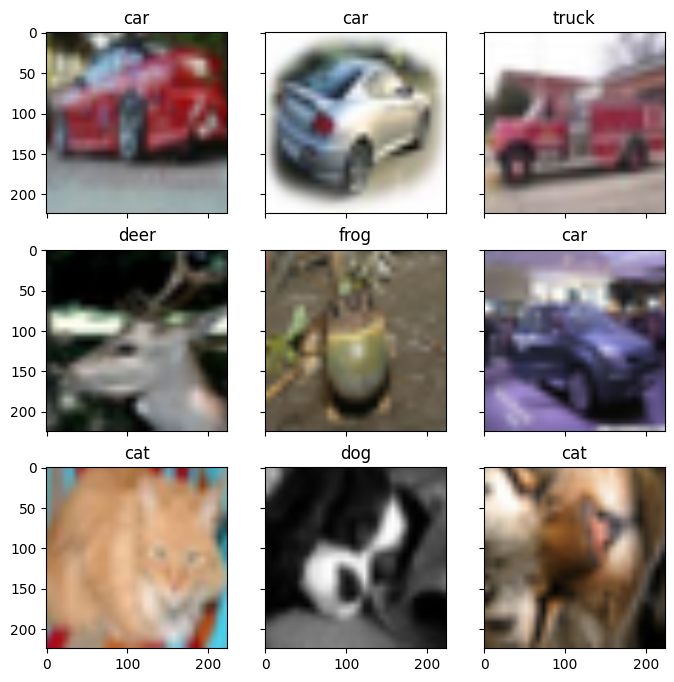

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_idx = int(np.random.uniform(0, len(testset)))
    im_val, label = testset[random_idx]

    img_label = classes[label]

    imshow(im_val, ax=fig_x, title=img_label)

plt.show()

#### Проверка на дисбаланс классов

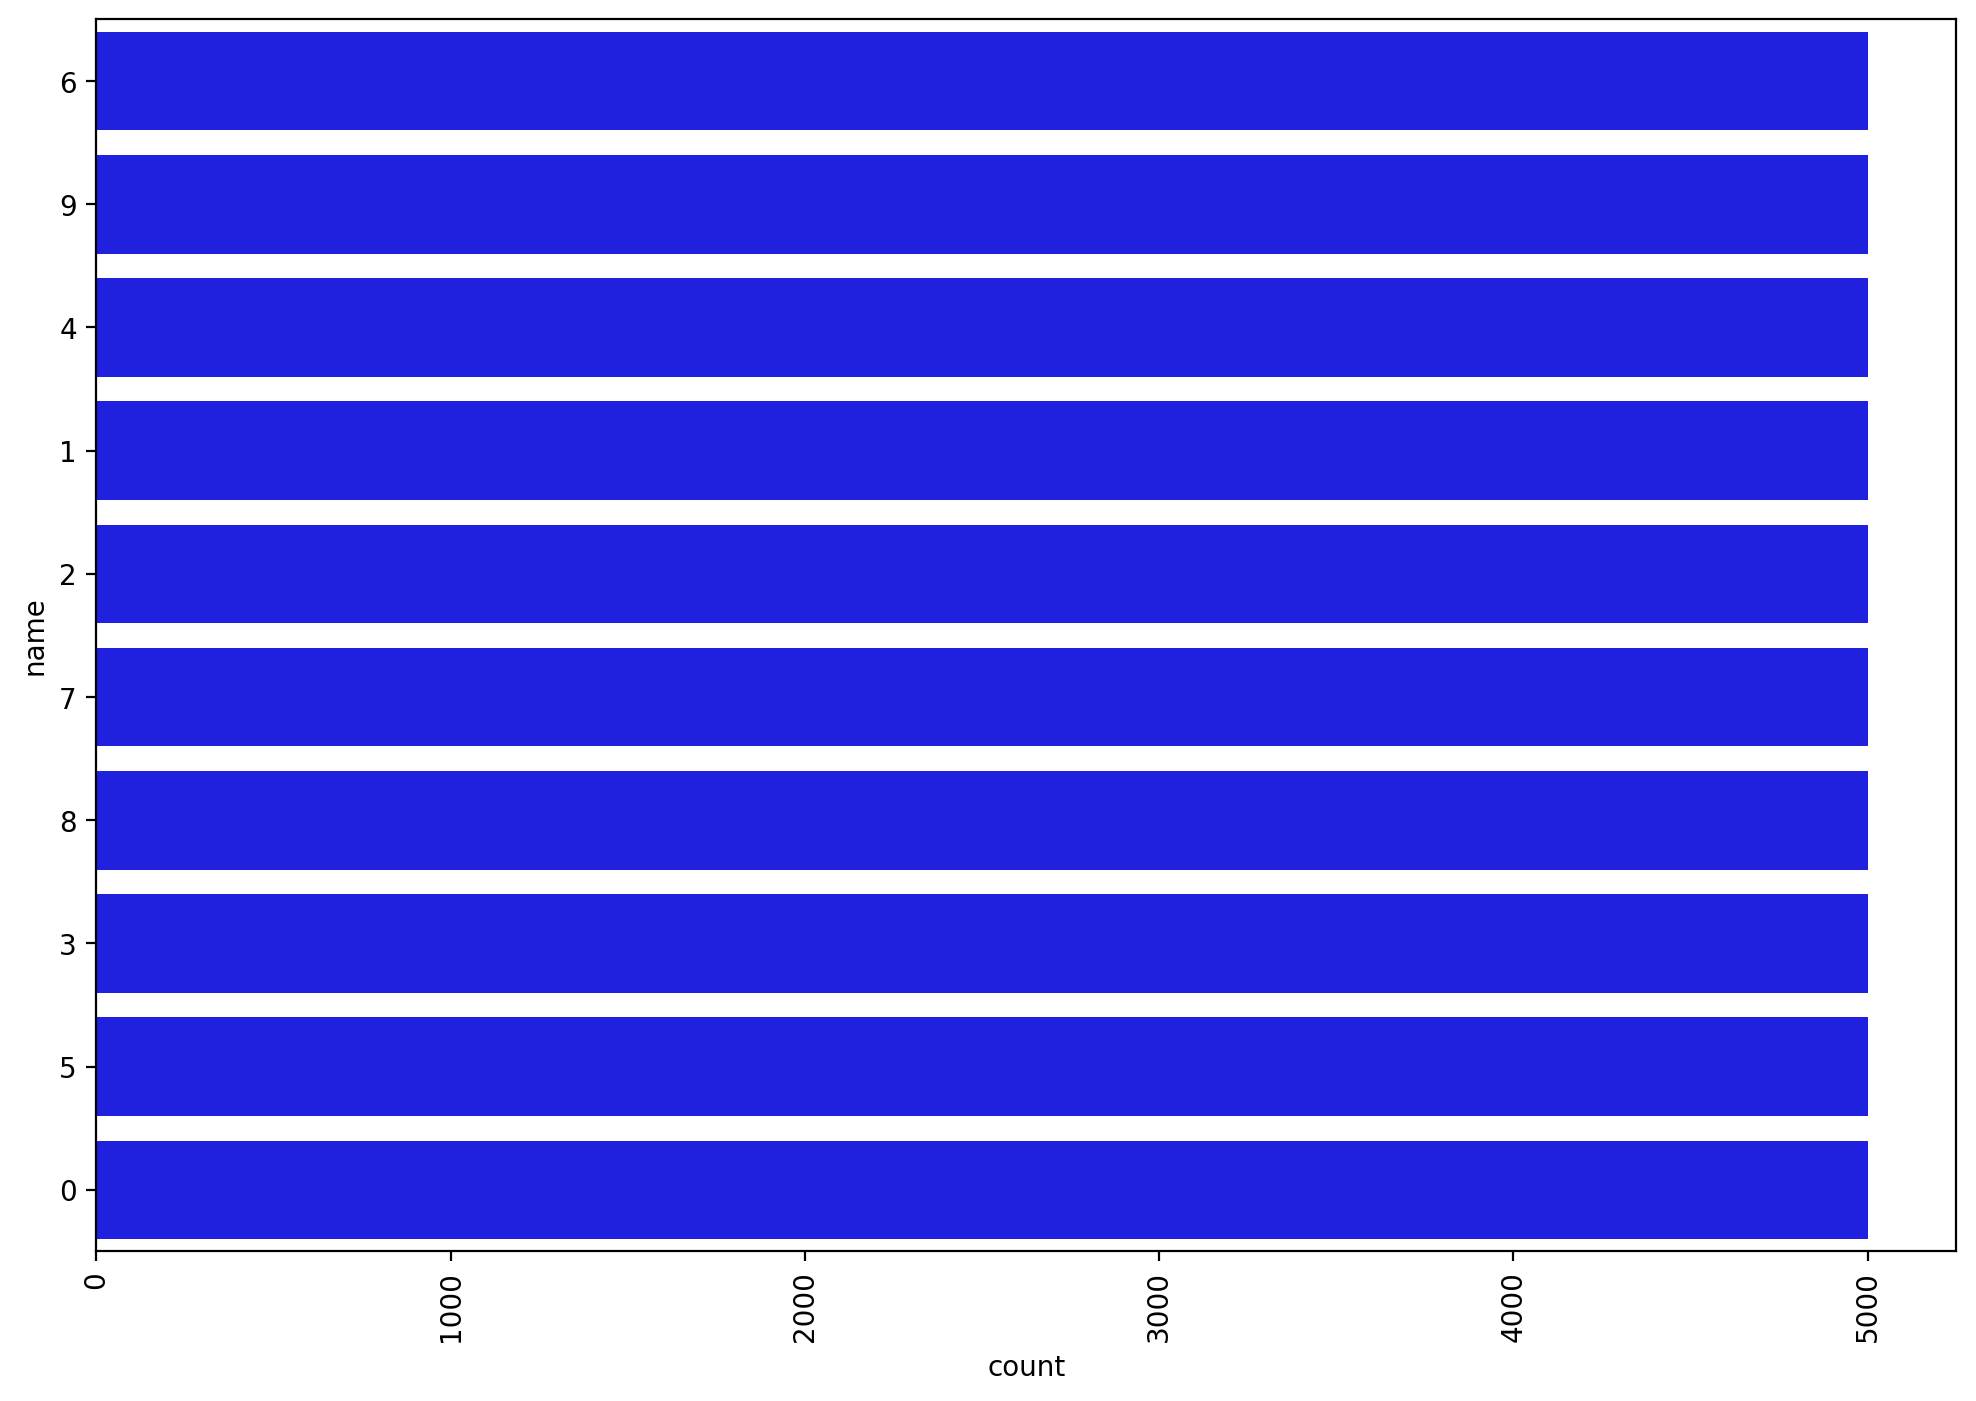

In [ ]:
train_labels = [label for _, label in trainset]

count_heroes_in_train = pd.DataFrame(data=train_labels, columns=["name"])

plt.figure(figsize=(12, 8),dpi=200)
plt.xticks(rotation=90)
sns.countplot(
    y="name",
    data=count_heroes_in_train,
    order=count_heroes_in_train["name"].value_counts().index,
    color="b",
    orient='h',
);

### Модель

#### ResNet -50 была выбрана молелью для обучения с нуля из за стабильности архитектуры и простоты использования в продакшене

In [ ]:
model = models.resnet50(pretrained=False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model.to(device)
device

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


device(type='cuda')

### Обучение

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm_notebook(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.double() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm_notebook(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(trainloader, testloader, model, epochs, batch_size):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    plt.ion()  # Включаем интерактивный режим для обновления графика

    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')

    train_loss_line, = ax.plot([], [], label='Train Loss')
    val_loss_line, = ax.plot([], [], label='Validation Loss')
    ax.legend()

    with tqdm_notebook(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.0005)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            model.train()
            train_loss, train_acc = fit_epoch(model, trainloader, criterion, opt)
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            scheduler.step()

            model.eval()
            val_loss, val_acc = eval_epoch(model, testloader, criterion)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            # Обновляем данные на графике
            train_loss_line.set_data(range(1, epoch + 2), history['train_loss'])
            val_loss_line.set_data(range(1, epoch + 2), history['val_loss'])

            # Устанавливаем пределы осей для графика
            ax.set_xlim(1, epoch + 2)
            ax.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])))

            # Обновляем график
            plt.pause(0.01)

    plt.ioff()  # Выключаем интерактивный режим после завершения обучения

    return history

def predict(models, test_loader):
    with torch.inference_mode():
        all_probs = []

        for model in models:
            model.eval()
            probs = []

            for inputs in test_loader:
                inputs = inputs.to(DEVICE)
                outputs = model(inputs).cpu()
                probs.append(outputs)

            probs = nn.functional.softmax(torch.cat(probs), dim=-1).numpy()
            all_probs.append(probs)

    avg_probs = np.mean(all_probs, axis=0)
    return avg_probs

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.5309     val_loss 2.7379 train_acc 0.4419 val_acc 0.2176


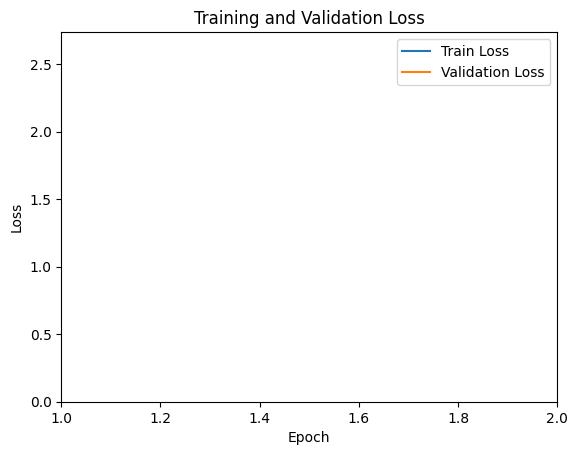

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


Epoch 002 train_loss: 1.0282     val_loss 1.9516 train_acc 0.6342 val_acc 0.4193


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.8247     val_loss 1.9866 train_acc 0.7126 val_acc 0.4268


  0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
history_resnet = train(trainloader, testloader, model=torch.nn.DataParallel(model), epochs=30, batch_size=64)

### Оценка результата

In [ ]:
loss = history_resnet['train_loss']
val_loss = history_resnet['val_loss']
acc = history_resnet['train_acc']
val_acc = history_resnet['val_acc']

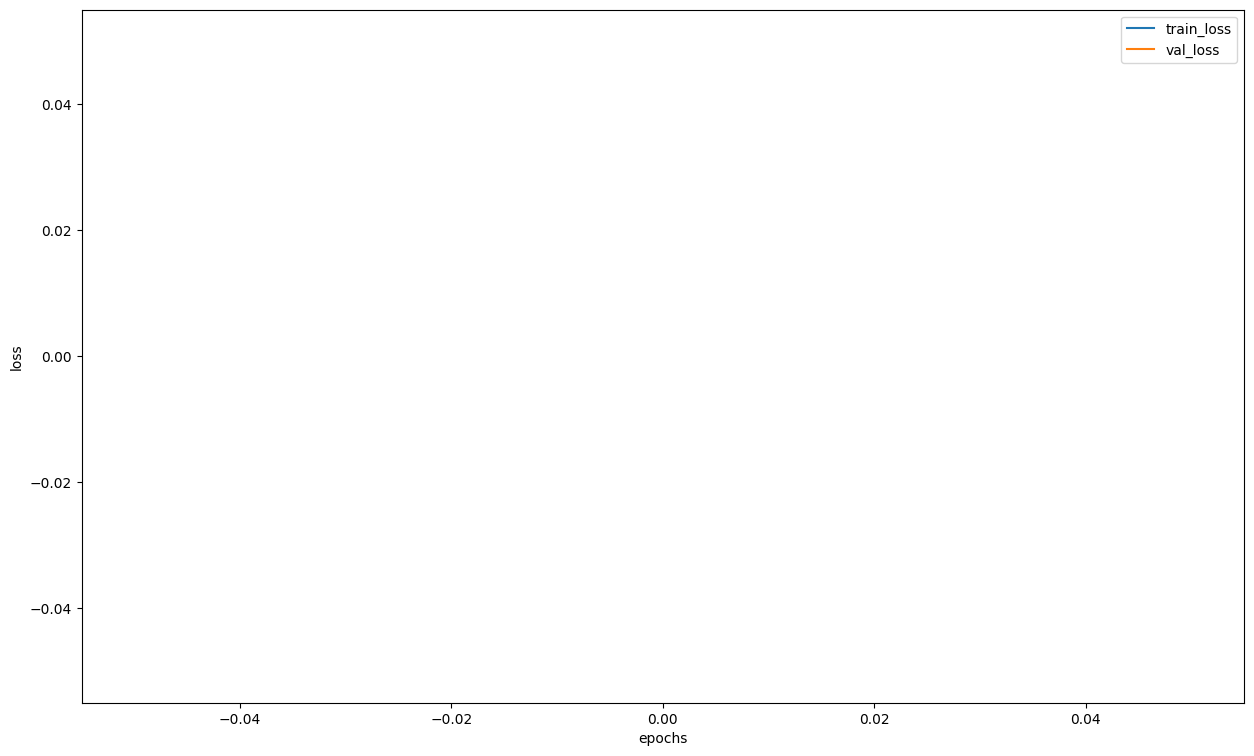

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_acc, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#### Алгоритм, чтобы проверить насколько наша модель уверена в своих предсказаниях

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = testset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [testset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [testset[id][1] for id in idxs]

preds_class = [classes[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

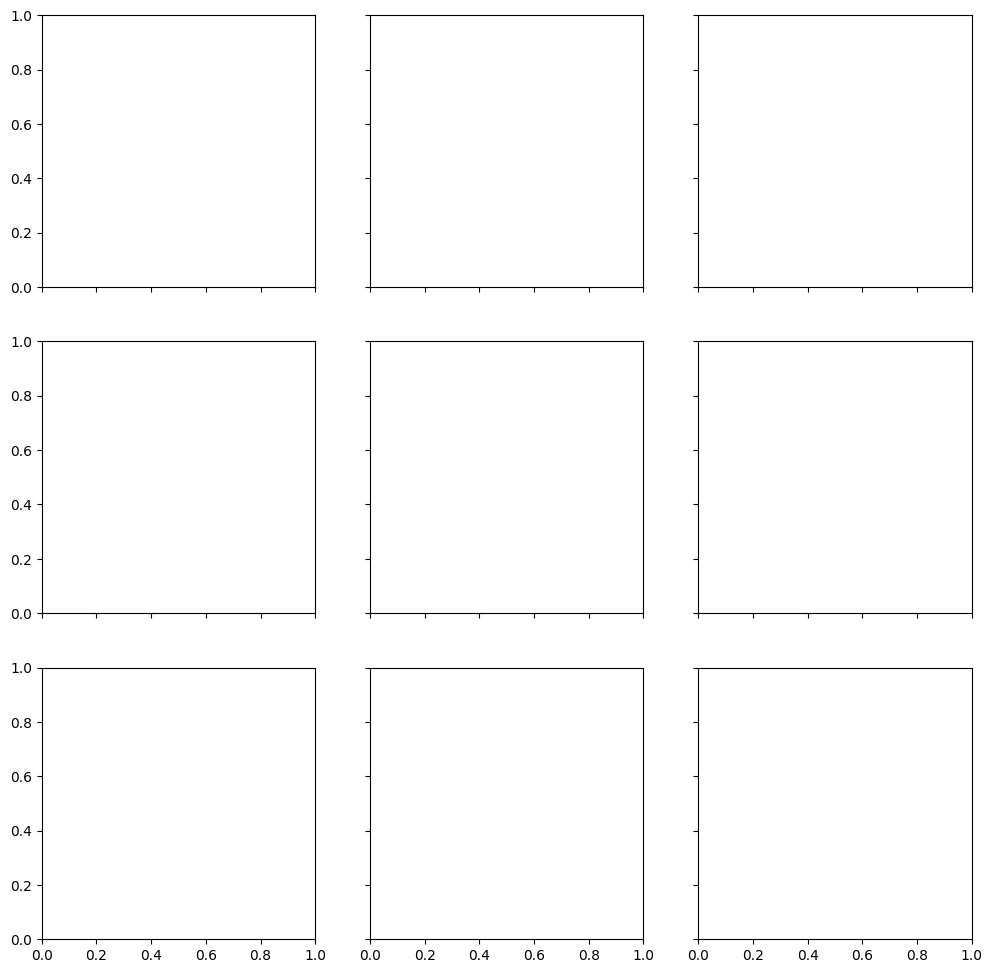

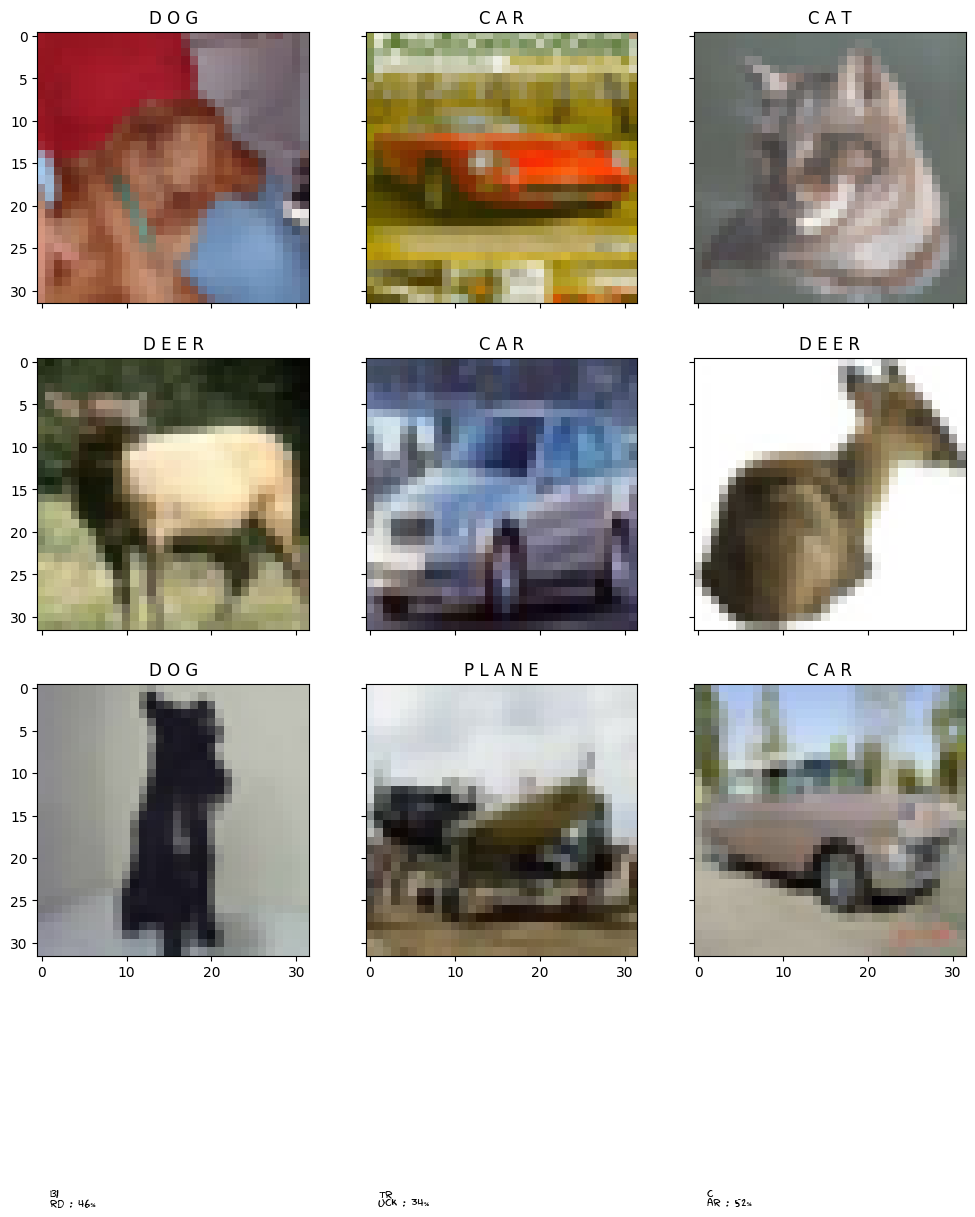

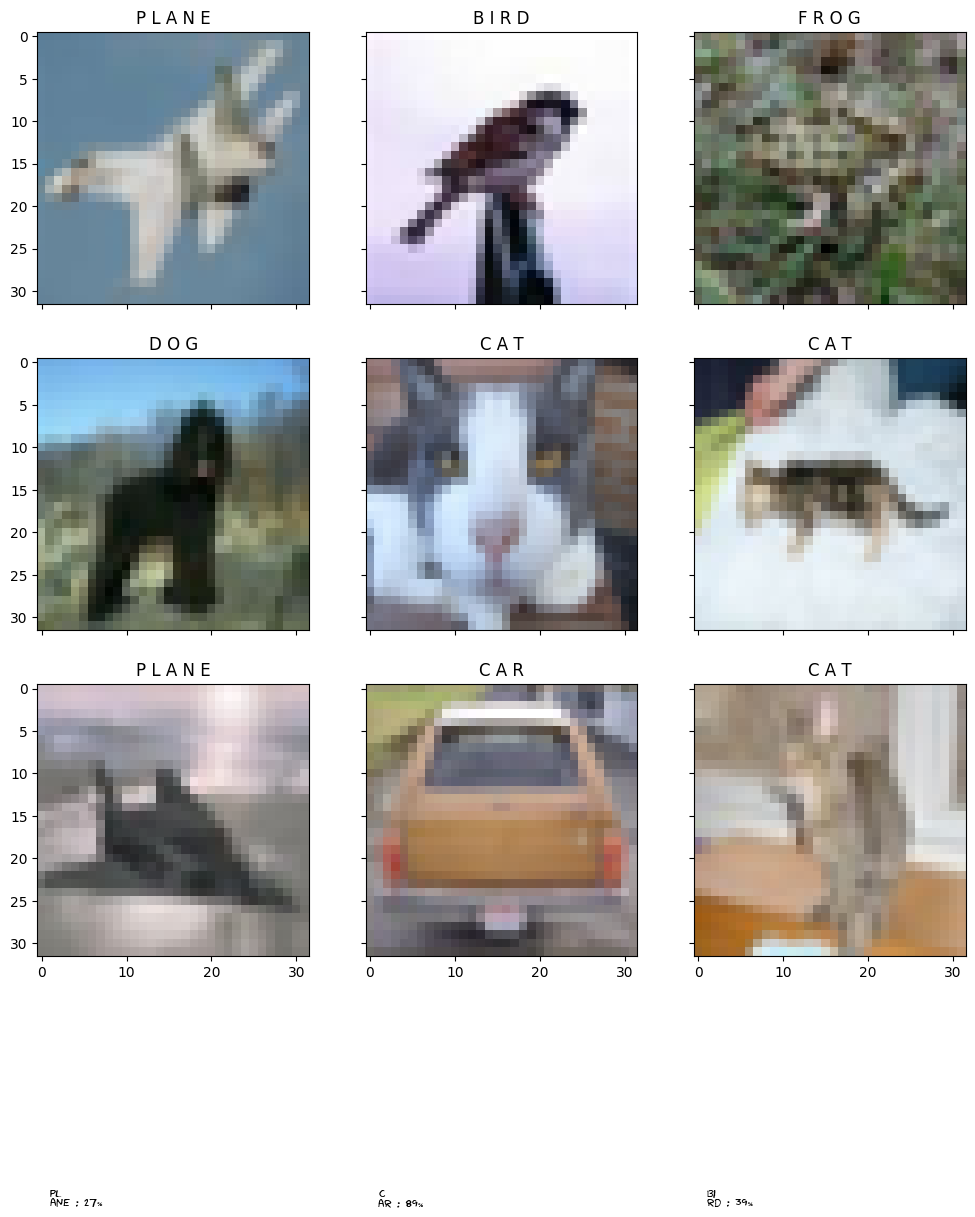

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = testset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                classes[label]))



    imshow(im_val.data.cpu(), \
          title=img_label,ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = classes[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

plt.show()

## Часть 2


1. Решите ту же задачу, но без ограничения на использование предобученных моделей.

2. Проведите сравнительный анализ результатов полученных в первой и второй части.


#### Претренированная модель была также взята ResNet 50, но уже с весами

In [ ]:
resnet = torchvision.models.resnet50(weights="IMAGENET1K_V2")

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(classes))
resnet = resnet.to(DEVICE)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


Epoch 001 train_loss: 0.1953     val_loss 0.2612 train_acc 0.9333 val_acc 0.9129


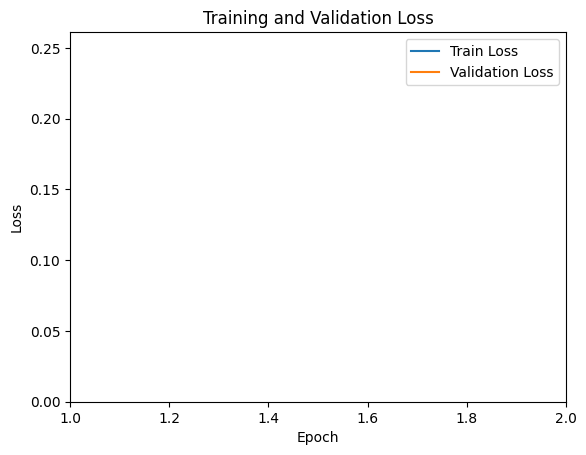

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.1226     val_loss 0.2346 train_acc 0.9575 val_acc 0.9262


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.0943     val_loss 0.2730 train_acc 0.9673 val_acc 0.9168


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.0751     val_loss 0.2491 train_acc 0.9739 val_acc 0.9240


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.0219     val_loss 0.1431 train_acc 0.9933 val_acc 0.9566


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


Epoch 006 train_loss: 0.0040     val_loss 0.1411 train_acc 0.9995 val_acc 0.9594


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


Epoch 007 train_loss: 0.0019     val_loss 0.1454 train_acc 0.9999 val_acc 0.9601


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


Epoch 008 train_loss: 0.0012     val_loss 0.1535 train_acc 0.9999 val_acc 0.9602


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


Epoch 009 train_loss: 0.0008     val_loss 0.1546 train_acc 1.0000 val_acc 0.9600


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


Epoch 010 train_loss: 0.0006     val_loss 0.1533 train_acc 1.0000 val_acc 0.9604


In [ ]:
history_resnet1 = train(trainloader, testloader, model=torch.nn.DataParallel(resnet), epochs=10, batch_size=64)

In [ ]:
loss1 = history_resnet1['train_loss']
val_loss1 = history_resnet1['val_loss']
acc1 = history_resnet1['train_acc']
val_acc1 = history_resnet1['val_acc']

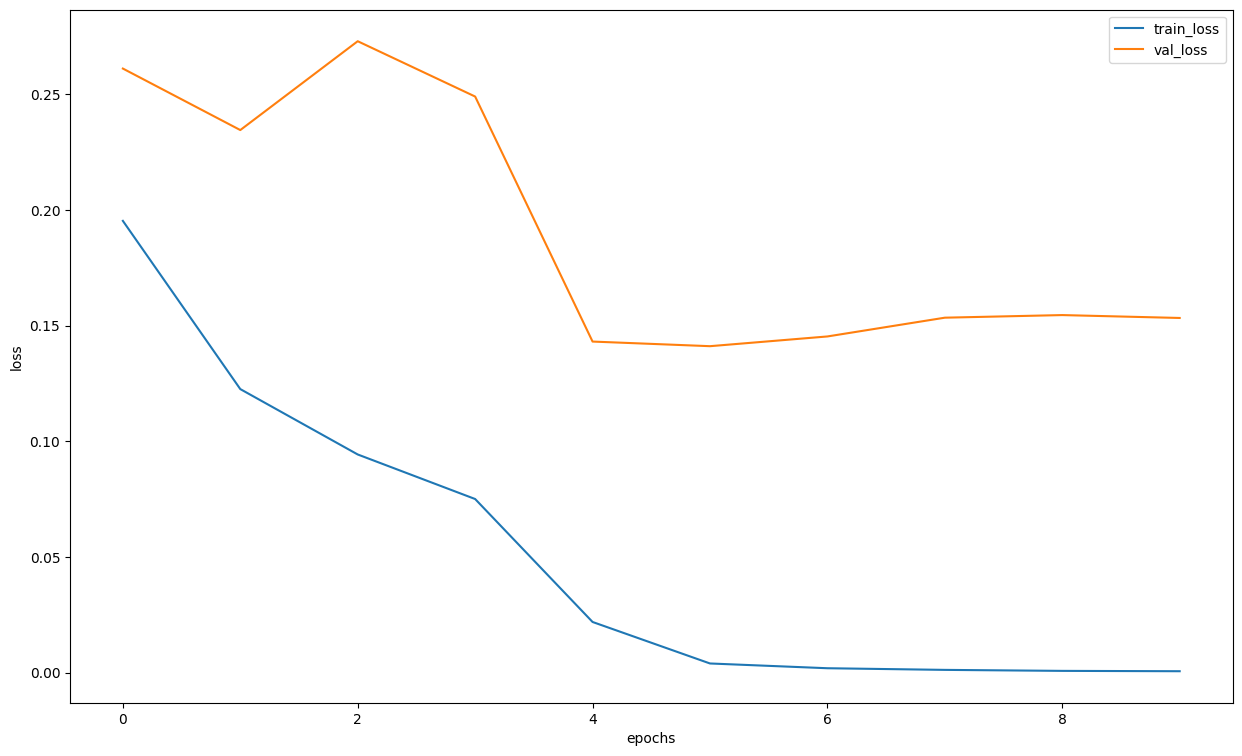

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss1, label="train_loss")
plt.plot(val_loss1, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Вывод

В работе с первой частью я пробовал использовать ViT трансформер готовую архитектуру, но он постоянно застревал на оптимизации и я не понял как это можно оптимизировать, поэтому в итоге после применения optuna я понял, что даже это не помогает и решил использовать везде стандартную архитектуру ResNet и в принципе для такой базовой ситуации без каких либо проблем с данными, все работает и показывает хорошие результаты. За метрику взял обычный accuracy, так как явной бизнес задачи нет для, которой можно было бы использовать precision или recall, и нет дисбаланса классов, что могло бы потребовать использовать f1 или ROC-AUC.